# Run Pharaglow 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features

### Load data and create binary masks 

In [2]:
%%time
# io
fname = "/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0014/*.tiff"
parameterfile = "/media/scholz_la/hd2/Nicolina/Nicolina/pharaglow_parameters_mks.txt"
outfile = "/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0014_{}_{}.json"
lawnfile = '/media/scholz_la/hd2/Nicolina/Nicolina/NZ0014_lawn.bmp'

print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes

print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)

if lawnfile is not None:
    print('open and binarize lawn file')
    lawn = pims.open(lawnfile)[0]
    binLawn = features.findLawn(lawn)

Starting pharaglow analysis...
Loading parameters from ['Nicolina', 'pharaglow_parameters_mks.txt']
open and binarize lawn file
CPU times: user 7.92 s, sys: 535 ms, total: 8.45 s
Wall time: 1.48 s


In [3]:
plt.figure(figsize=(15,8))
plt.imshow(binLawn)

In [93]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'])


Binarizing images
CPU times: user 39.5 s, sys: 1.4 s, total: 40.9 s
Wall time: 4.76 s


### Make sure the thesholding worked otherwise change parameters

In [4]:
t = 1000
plt.figure(figsize=(18,11))
# plt.subplot(121)
plt.imshow(rawframes[t])
# plt.subplot(122)
plt.imshow(masks[t])#[:,2500:])
print(np.sum(masks[t][:,2500:]))

NameError: name 'rawframes' is not defined

<Figure size 1296x792 with 0 Axes>

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [96]:
%%time
import time

nWorkers = 10
if nWorkers ==1:

    #masks = tracking.preprocess(rawframes, minSize = param['minSize'], threshold =None )
    print('Detecting features')
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    from multiprocessing import Pool
    print('Detecting features')
    def f(sl):
        a,b = sl
        #print(a,b)
        return tracking.runfeatureDetection(rawframes[a:b], masks[a:b], param, frameOffset = a)
    features = []
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    print(L)
    chunksize = L//nWorkers//20
    #slices = np.arange(L)
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    
    p = Pool(nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(f, slices)):
        features.append(res)
        if k ==10:
            print('Expected time is approx. {} s'.format(L/chunksize*(time.time()-start)/nWorkers))
        #print(p, time.time()-start)
    features = pd.concat(features)

Detecting features
2243
Expected time is approx. 281.6142773079872 s
CPU times: user 2.43 s, sys: 2.71 s, total: 5.15 s
Wall time: 6min 12s


In [98]:

### Save the features
plt.plot(np.sort(features['area'].values))

In [99]:
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14139 entries, 0 to 0
Data columns (total 8 columns):
area     14139 non-null int64
frame    14139 non-null int64
image    14139 non-null object
slice    14139 non-null object
x        14139 non-null float64
xw       14139 non-null float64
y        14139 non-null float64
yw       14139 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 3.0 MB


In [36]:
features = pd.read_json(outfile.format('features', 'all'), orient='split', numpy = True)

In [101]:
print('Done')
print('Linking trajectories')
#trajectories = tracking.linkParticles(features, param['searchRange'], param['minimalDuration'])
#trajectories = tracking.linkParticles(features, 50, 500);
#trajectories = tp.link_df(features, 50, memory= 30)
#trajectories = tp.filter_stubs(trajectories,100)
pred = tp.predict.NearestVelocityPredict()
trajectories = pred.link_df(features, 10, memory= 300)

Frame 2239: 1 trajectories present.


In [102]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,300)
print(trajectories['particle'].nunique())

1840
6


### Extract lawn info

In [9]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

CPU times: user 35.9 s, sys: 1.9 s, total: 37.8 s
Wall time: 37.7 s


### Show resulting trajectories

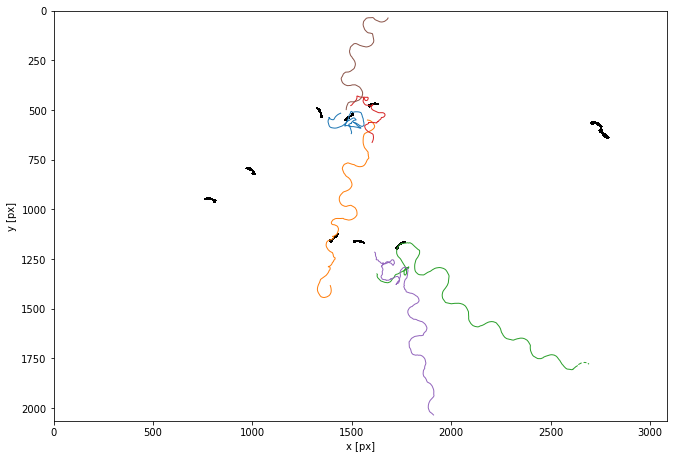

In [103]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories[trajectories['frame']], superimpose=1-masks[0]);

In [3]:
trajectories.to_json(outfile.format('trajectories', 'all'), orient='split')

NameError: name 'trajectories' is not defined

In [11]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

### run the whole pharaglow feature extraction

In [12]:
# # read data
# trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)

In [5]:
# %%time
# print('Extracting pharynx data')
# trajectories = parallelize_dataframe(trajectories, run.runPharaglowOnStack, n_cores = 20, params = param)
# print('Done tracking. Successfully tracked {} frames with {} trajectorie(s).'.format(len(rawframes), trajectories['particle'].nunique()))

### Save data as hdf5 format (every trajectory in a file)

In [14]:
%%time
#trajectories.info(memory_usage='deep')

for particle_index in trajectories['particle'].unique():
    tmp = parallelize_dataframe(trajectories[trajectories.loc[:,'particle'] == particle_index], run.runPharaglowOnStack, n_cores = 10, params = param)
    tmp.to_json(outfile.format('results', particle_index), orient='split')

[234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 233, 233, 233, 233, 233, 233, 233, 233]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

99
[509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 508, 508, 508, 508, 508, 508, 508, 508]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

142
[127, 127, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 90 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 96 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

109
[352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 351, 351]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

80
[684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


112
[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


110
[58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 57, 57, 57, 57, 57, 57, 57, 57, 57]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

120
[129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

80
[25, 25, 25, 25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

98
[223, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnume

108
[600, 600, 600, 600, 600, 600, 600, 600, 600, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


96
[197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 196, 196, 196, 196]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 109 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

86
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 20]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

81
[538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 537, 537]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
94
[51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

109
[46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
85
[176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 175, 175]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



118
[65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64, 64, 64]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


105
[60, 60, 60, 60, 60, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

112
[68, 68, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

84
[266, 266, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 112 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 111 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 104 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


130
[183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


105
CPU times: user 2min 57s, sys: 1min 49s, total: 4min 46s
Wall time: 53min 4s
